# **Importing libraries**

In [ ]:

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tqdm import tqdm
import matplotlib.pyplot as plt


# **Data Loading and Preprocessing**

In [ ]:
!kaggle datasets download -d meetnagadia/kvasir-dataset/

Dataset URL: https://www.kaggle.com/datasets/meetnagadia/kvasir-dataset/versions/
License(s): ODbL-1.0
 98% 1.13G/1.15G [00:18<00:00, 64.9MB/s]
100% 1.15G/1.15G [00:18<00:00, 66.6MB/s]


In [ ]:
!unzip "/content/kvasir-dataset.zip"

Archive:  /content/kvasir-dataset.zip
  inflating: kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/018ed8ed-e489-4bbb-8a99-3346db9ec160.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/0195c5a6-5ddf-471c-9868-2ea66b81f440.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01d38b8f-74b2-4147-9519-448d05bf8745.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/02c10865-9d23-4f6b-aa5d-f73b63b6d67f.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/031a6e89-d3b7-48c8-8e2f-db991030f959.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/03a49a2e-c8d4-4dcd-b5e7-3d1722ed5db3.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/041daea7-c9cd-4

In [ ]:
# Cell 3: Preparing the Dataset
# Path to the dataset
dataset_path = '/content/kvasir-dataset'

# Lists to store file paths and labels
image_paths = []
labels = []

# Loop through each folder in the dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Find all image files in the folder
        for img_file in glob.glob(os.path.join(folder_path, '*.jpg')):
            image_paths.append(img_file)
            labels.append(folder_name)

# Convert lists to pandas DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Perform train-test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

print(f'Training samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')


Training samples: 3200
Test samples: 800


In [ ]:
# Cell 4: Data Loading and Preprocessing Functions
def load_image(image_path, label, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def encode_labels(label, class_names):
    label = tf.argmax(tf.constant(class_names) == label)
    return label

class_names = data['label'].unique().tolist()

train_data['label'] = train_data['label'].apply(lambda x: encode_labels(x, class_names))
test_data['label'] = test_data['label'].apply(lambda x: encode_labels(x, class_names))

train_dataset = tf.data.Dataset.from_tensor_slices((train_data['image_path'].values.tolist(), train_data['label'].values.tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data['image_path'].values.tolist(), test_data['label'].values.tolist()))

# Map loading function to datasets
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(train_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# **ResNet Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout

base_model = ResNet50(weights='imagenet', include_top=False)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Building BAM Model**

In [ ]:
class Flatten(Layer):
    def call(self, x):
        return tf.keras.layers.Flatten()(x)
class ChannelGate(Layer):
    def __init__(self, gate_channel, reduction_ratio=16, num_layers=1, **kwargs):
        super(ChannelGate, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.gate_channels = [gate_channel]
        self.gate_channels += [gate_channel // reduction_ratio] * num_layers
        self.gate_channels += [gate_channel]

        self.dense_layers = []
        for i in range(len(self.gate_channels) - 2):
            self.dense_layers.append(Dense(self.gate_channels[i+1], use_bias=False))
            self.dense_layers.append(BatchNormalization())
            self.dense_layers.append(ReLU())

        self.dense_layers.append(Dense(self.gate_channels[-1], use_bias=False))

    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        x = self.flatten(avg_pool)
        for layer in self.dense_layers:
            x = layer(x)
        x = tf.reshape(x, (-1, 1, 1, x.shape[-1]))
        return x
class SpatialGate(Layer):
    def __init__(self, gate_channel, reduction_ratio=16, dilation_conv_num=2, dilation_val=4, **kwargs):
        super(SpatialGate, self).__init__(**kwargs)
        self.conv_reduce = Conv2D(gate_channel // reduction_ratio, kernel_size=1, padding='same', use_bias=False)
        self.bn_reduce = BatchNormalization()
        self.relu = ReLU()

        self.dilation_conv_num = dilation_conv_num
        self.dilation_val = dilation_val

        self.dilation_convs = []
        for _ in range(dilation_conv_num):
            self.dilation_convs.append(Conv2D(gate_channel // reduction_ratio, kernel_size=3, padding='same', dilation_rate=dilation_val, use_bias=False))
            self.dilation_convs.append(BatchNormalization())
            self.dilation_convs.append(ReLU())

        self.conv_final = Conv2D(1, kernel_size=1, padding='same', use_bias=False)

    def call(self, x):
        x = self.conv_reduce(x)
        x = self.bn_reduce(x)
        x = self.relu(x)

        for conv in self.dilation_convs:
            x = conv(x)

        x = self.conv_final(x)
        return x
class BAM(Layer):
    def __init__(self, gate_channel, **kwargs):
        super(BAM, self).__init__(**kwargs)
        self.channel_att = ChannelGate(gate_channel)
        self.spatial_att = SpatialGate(gate_channel)

    def call(self, x):
        channel_att = self.channel_att(x)
        spatial_att = self.spatial_att(x)
        att = 1 + tf.sigmoid(channel_att * spatial_att)
        return Multiply()([att, x])


In [ ]:
from tensorflow.keras.applications import ResNet50
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Add ResNet as a feature extractor
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = resnet(inputs)

    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BAM(64)(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(8, activation='softmax')(x)  # Example for 8 classes

    model = Model(inputs, outputs)
    return model

bam_model = create_model((224, 224, 3))  # Example input shape
bam_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bam (BAM)                            │ (None, 7, 7, 64)            │           1,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,853,004 (94.81 MB)

 Trainable params: 24,799,852 (94.60 MB)

 Non-trainable params: 53,152 (207.62 KB)

# **Building CBAM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Dense, BatchNormalization, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Add, Multiply, Concatenate, Input
from tensorflow.keras.applications import InceptionV3
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Define CBAM Module

class Flatten(Layer):
    def call(self, x):
        return tf.keras.layers.Flatten()(x)

class BasicConv(Layer):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding='same', dilation=1, groups=1, relu=True, bn=True, bias=False, **kwargs):
        super(BasicConv, self).__init__(**kwargs)
        self.conv = Conv2D(out_planes, kernel_size=kernel_size, strides=stride, padding=padding,
                           dilation_rate=dilation, groups=groups, use_bias=bias)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01) if bn else None
        self.relu = ReLU() if relu else None

    def call(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class ChannelGate(Layer):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], **kwargs):
        super(ChannelGate, self).__init__(**kwargs)
        self.gate_channels = gate_channels
        self.reduction_ratio = reduction_ratio
        self.pool_types = pool_types
        self.flatten = Flatten()
        self.mlp = tf.keras.Sequential([
            Dense(gate_channels // reduction_ratio, activation='relu'),
            Dense(gate_channels)
        ])

    def call(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = GlobalAveragePooling2D()(x)
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = GlobalMaxPooling2D()(x)
                channel_att_raw = self.mlp(max_pool)
            elif pool_type == 'lp':
                lp_pool = self.lp_pool2d(x)
                channel_att_raw = self.mlp(lp_pool)
            elif pool_type == 'lse':
                lse_pool = self.logsumexp_2d(x)
                channel_att_raw = self.mlp(lse_pool)
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = Add()([channel_att_sum, channel_att_raw])
        scale = tf.keras.activations.sigmoid(channel_att_sum)
        scale = tf.reshape(scale, (-1, 1, 1, self.gate_channels))
        return Multiply()([x, scale])

    def lp_pool2d(self, x, p=2):
        return tf.reduce_sum(tf.pow(x, p), axis=[1, 2], keepdims=True)

    def logsumexp_2d(self, x):
        x_flatten = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[3], -1))
        s = tf.reduce_max(x_flatten, axis=2, keepdims=True)
        outputs = s + tf.math.log(tf.reduce_sum(tf.exp(x_flatten - s), axis=2, keepdims=True))
        return outputs

class ChannelPool(Layer):
    def call(self, x):
        return Concatenate(axis=-1)([tf.reduce_max(x, axis=3, keepdims=True), tf.reduce_mean(x, axis=3, keepdims=True)])

class SpatialGate(Layer):
    def __init__(self, **kwargs):
        super(SpatialGate, self).__init__(**kwargs)
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size=7, stride=1, padding='same', relu=False)

    def call(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = tf.keras.activations.sigmoid(x_out)
        return Multiply()([x, scale])

class CBAM(Layer):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_gate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.spatial_gate = SpatialGate()

    def call(self, x):
        x_out = self.channel_gate(x)
        if not self.no_spatial:
            x_out = self.spatial_gate(x_out)
        return x_out


In [ ]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Load InceptionV3 model without top layers
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # Output from InceptionV3 base model
    x = base_model.output

    # Apply CBAM to the output of InceptionV3
    x = CBAM(gate_channels=x.shape[-1])(x)  # Adjust gate_channels to match the output of InceptionV3

    # Add additional layers
    x = BasicConv(x.shape[-1], 256, kernel_size=3)(x)
    x = BasicConv(256, 512, kernel_size=3)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Model compilation, training, and evaluation

input_shape = (224, 224, 3)  # Example input shape
num_classes = 8  #  number of classes

cbam_model = build_model(input_shape, num_classes)

cbam_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'channel_gate_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 30,019,694 (114.52 MB)

 Trainable params: 29,965,036 (114.31 MB)

 Non-trainable params: 54,658 (213.51 KB)

# **GRAD_CAM**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_grad_cam(model, img, class_index, last_conv_layer_name):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, class_index]

    # Compute the gradient of the class score with respect to the feature map
    grads = tape.gradient(loss, conv_outputs)

    # Compute the mean intensity of the gradient over each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its corresponding gradient
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads

    # Generate heatmap
    heatmap = np.mean(conv_outputs, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def display_grad_cam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use jet colormap to apply color to heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


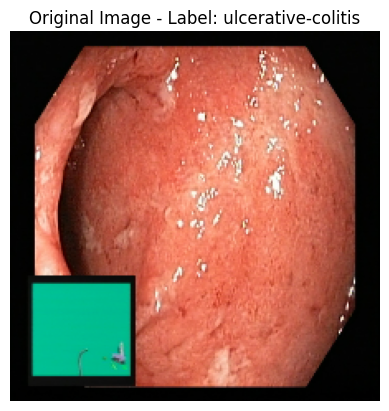

In [ ]:
# Sample image from the test dataset
sample_image, label = next(iter(test_dataset.take(1)))

plt.imshow(sample_image[0])
plt.axis('off')
plt.title(f'Original Image - Label: {class_names[label[0]]}')  # Display the label
plt.show()

sample_image = sample_image[0].numpy()

## **ResNet Model Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<ipython-input-11-ce6c1930f6ec>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


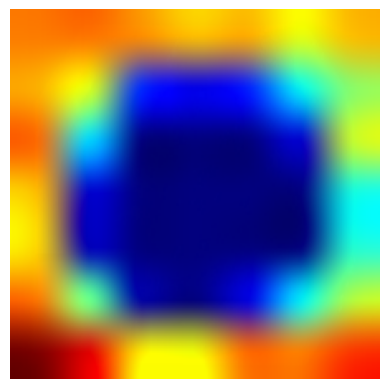

In [ ]:
# Get model's prediction for the sample image
predictions = model.predict(np.array([sample_image]))
predicted_class = np.argmax(predictions)

# Generate Grad-CAM heatmap for the predicted class
heatmap = get_grad_cam(model, sample_image, predicted_class, last_conv_layer_name='conv5_block3_3_conv')

# Display the image with the Grad-CAM heatmap
superimposed_img = display_grad_cam(sample_image, heatmap)
plt.imshow(superimposed_img)
plt.axis('off')  # Hide axis
plt.show()

## **BAM Model Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


<ipython-input-11-ce6c1930f6ec>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


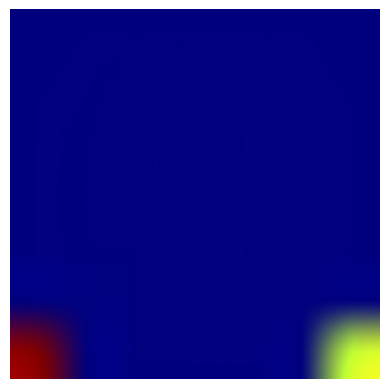

In [ ]:
# Get model's prediction for the sample image
predictions = bam_model.predict(np.array([sample_image]))
predicted_class = np.argmax(predictions)

# Generate Grad-CAM heatmap for the predicted class
heatmap = get_grad_cam(bam_model, sample_image, predicted_class, last_conv_layer_name='bam')

# Display the image with the Grad-CAM heatmap
superimposed_img = display_grad_cam(sample_image, heatmap)
plt.imshow(superimposed_img)
plt.axis('off')  # Hide axis
plt.show()


## **CBAM Model Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


<ipython-input-11-ce6c1930f6ec>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


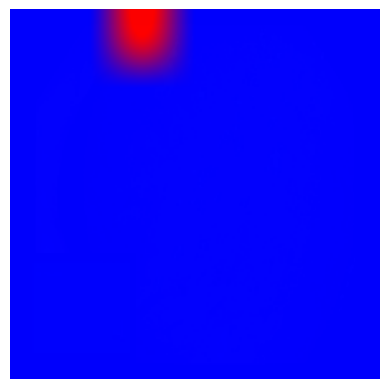

In [ ]:
# Get model's prediction for the sample image
predictions = cbam_model.predict(np.array([sample_image]))
predicted_class = np.argmax(predictions)

# Generate Grad-CAM heatmap for the predicted class
heatmap = get_grad_cam(cbam_model, sample_image, predicted_class, last_conv_layer_name='cbam')

# Display the image with the Grad-CAM heatmap
superimposed_img = display_grad_cam(sample_image, heatmap)
plt.imshow(superimposed_img)
plt.axis('off')  # Hide axis
plt.show()
